In [15]:
import os
import argparse
import glob
import sys 
import yaml 
import glob

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.backends.backend_pdf import PdfPages

from scipy import interpolate 
from scipy import signal

from pathlib import Path
sys.path.append(str(Path('.').absolute().parent.parent))
from util.paths import find, list_subdirs

import matplotlib as mpl
mpl.rcParams.update({'font.size':         24,
                     'axes.linewidth':    3,
                     'xtick.major.size':  5,
                     'xtick.major.width': 2,
                     'ytick.major.size':  5,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':  "Arial",
                     'font.family':      "sans-serif",
                    })
pd.set_option('display.max_rows', None)


In [3]:
trial=1
base_path = Path('~/NewMonster/T/OptoPreyCapture').expanduser()
fpath = str(list((base_path / '051821/PVCH12p10/trial_{:d}/'.format(trial)).glob('*_BasicParams.h5'))[0])


In [4]:
with pd.HDFStore(fpath) as store:
    data = store['df']
    metadata = store.get_storer('df').attrs.metadata

In [38]:
csv2

,animal_name,experiment_date,Weight,Unnamed: 3,Trial_1,Trial_2,Trial_3,Trial_4,Total,Food Deprived?,Wallpaper,videos run DLC,Notes,experiment_outcome,computer,drive,Trial,LaserOn
0,PVCH12p10,061821,22.5,NaN,0:03,0:19*,0:10,0:44*,NaN,yes,"low sf wallpaper, just fibers, continuous laser",NaN,NaN,good,new-monster,T,1,False
1,PVCH12p10,061821,22.5,NaN,0:03,0:19*,0:10,0:44*,NaN,yes,"low sf wallpaper, just fibers, continuous laser",NaN,NaN,good,new-monster,T,2,True
2,PVCH12p10,061821,22.5,NaN,0:03,0:19*,0:10,0:44*,NaN,yes,"low sf wallpaper, just fibers, continuous laser",NaN,NaN,good,new-monster,T,3,False
3,PVCH12p10,061821,22.5,NaN,0:03,0:19*,0:10,0:44*,NaN,yes,"low sf wallpaper, just fibers, continuous laser",NaN,NaN,good,new-monster,T,4,True
4,PVCH12p11a,061821,21.5,NaN,0:36,0:58*,0:47,0:07*,NaN,yes,"low sf wallpaper, just fibers, continuous laser",trials 1 and 2 are good examples of laser effe...,NaN,good,new-monster,T,1,False
5,PVCH12p11a,061821,21.5,NaN,0:36,0:58*,0:47,0:07*,NaN,yes,"low sf wallpaper, just fibers, continuous laser",trials 1 and 2 are good examples of laser effe...,NaN,good,new-monster,T,2,True
6,PVCH12p11a,061821,21.5,NaN,0:36,0:58*,0:47,0:07*,NaN,yes,"low sf wallpaper, just fibers, continuous laser",trials 1 and 2 are good examples of laser effe...,NaN,good,new-monster,T,3,False
7,PVCH12p11a,061821,21.5,NaN,0:36,0:58*,0:47,0:07*,NaN,yes,"low sf wallpaper, just fibers, continuous laser",trials 1 and 2 are good examples of laser effe...,NaN,good,new-monster,T,4,True
8,PVCH13p3RT,061821,22.3,NaN,0:53,0:12*,0:50,0:48*,NaN,yes,"low sf wallpaper, just fibers, continuous laser",I lifted the commutator a little on trial 2 to...,NaN,good,new-monster,T,1,False
9,PVCH13p3RT,061821,22.3,NaN,0:53,0:12*,0:50,0:48*,NaN,yes,"low sf wallpaper, just fibers, continuous laser",I lifted the commutator a little on trial 2 to...,NaN,good,new-monster,T,2,True


In [86]:
with PdfPages(fpath[:-3] + '_Plots.pdf') as pdf:
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(data['t'],data['Angle'], c='b')
    ax.plot(data['t'],data['Speed'], c='k')
    ax.plot(data['t'],data['Dist'], c='m')
    ax.axvline(x=metadata['TimeToApproach'], c='g')
    ax.axvline(x=metadata['CaptureT'], c='r')
    ax.set_title('Basic Params')
    ax.legend(['Angle', 'Speed', 'Dist. to Cricket', 'TimeToApproach', 'CaptureT'], bbox_to_anchor=(1.01, 1), fontsize=10)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

    fig, ax = plt.subplots(figsize=(10,8))
    plot_min, plot_max = np.nanmin(data[['Mouse_x','Mouse_y','Cricket_x','Cricket_y']].to_numpy()), np.nanmax(data[['Mouse_x','Mouse_y','Cricket_x','Cricket_y']].to_numpy())
    ax.plot(data['Mouse_y'], data['Mouse_x'],c='k')
    ax.plot(data['Cricket_y'], data['Cricket_x'],c='r')
    ax.set_xlim([plot_min-1,plot_max+1])
    ax.set_ylim([plot_min-1,plot_max+1])
    ax.set_title('DLC Tracking')
    ax.legend(['Mouse', 'Cricket'],bbox_to_anchor=(1.01, 1), fontsize=10)
    ax.set_aspect('equal', 'box')
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

In [18]:
# csv_filepath = os.path.normpath('T:/OptoPreyCapture/csv_today.csv')
csv_filepath = base_path / 'csv_today.csv'
csv = pd.read_csv(csv_filepath)
csv['experiment_date'] = pd.to_datetime(csv['experiment_date'],infer_datetime_format=True,format='%m%d%Y').dt.strftime('%m%d%y')
csv = csv.loc[(csv['run_preprocessing'] == True)|(csv['run_ephys_analysis'] == True)]
csv = csv[csv['experiment_outcome']=='good'].reset_index(drop=True)
# Format Pandas Dataframe to have Trial number and Stimulus condition

cols = list(csv.keys()[:-4])
cols.append('Trial')
cols.append('LaserOn')
csv2 = pd.DataFrame(columns=cols)
for ind,row in csv.iterrows():
    for n in range(1,5):
        if '*' in row['Trial_{:d}'.format(n)]:
            csv2 = csv2.append(row[:-4].append(pd.Series([n,True],index=['Trial','LaserOn'])),ignore_index=True)
        else:
            csv2 = csv2.append(row[:-4].append(pd.Series([n,False],index=['Trial','LaserOn'])),ignore_index=True)
inds, labels = csv2['Wallpaper'].factorize()

In [23]:
df_meta = pd.DataFrame(columns=list(metadata.keys()))
for ind, row in csv2.iterrows():
    fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'trial_{:d}'.format(row['Trial'])).glob('*_BasicParams.h5'))[0])
    with pd.HDFStore(fname) as store:
        data = store['df']
        metadata = store.get_storer('df').attrs.metadata
        metadata.update(csv2[['animal_name','experiment_date','Trial','LaserOn','Wallpaper']].iloc[ind])
        df_meta = df_meta.append(metadata, ignore_index=True)

In [24]:
df_meta.groupby(['LaserOn','Wallpaper']).mean()

MovieT  \
LaserOn Wallpaper                                                       
False   6-2x2 black legos, high sf wallpaper, just fibe...  43.781667   
        6-2x2 black legos, white wallpaper, just fibers...  51.458333   
        high sf wallpaper, just fibers, continuous laser    31.797917   
        low sf wallpaper, just fibers, continuous laser     29.863333   
        white wallpaper, just fibers, continuous laser      20.872917   
True    6-2x2 black legos, high sf wallpaper, just fibe...  48.275000   
        6-2x2 black legos, white wallpaper, just fibers...  52.752083   
        high sf wallpaper, just fibers, continuous laser    40.970833   
        low sf wallpaper, just fibers, continuous laser     31.418333   
        white wallpaper, just fibers, continuous laser      17.987500   

                                                             CaptureT  \
LaserOn Wallpaper                                                       
False   6-2x2 black legos, high sf wallpaper, just fibe...  38.856667   
        6-2x2 black legos, white wallpaper, just fibers...  46.939583   
        high sf wallpaper, just fibers, continuous laser    27.043750   
        low sf wallpaper, just fibers, continuous laser     25.776667   
        white wallpaper, just fibers, continuous laser      16.439583   
True    6-2x2 black legos, high sf wallpaper, just fibe...  42.913889   
        6-2x2 black legos, white wallpaper, just fibers...  48.935417   
        high sf wallpaper, just fibers, continuous laser    36.631250   
        low sf wallpaper, just fibers, continuous laser     26.715000   
        white wallpaper, just fibers, continuous laser      14.214583   

                                                            TimeToApproach  \
LaserOn Wallpaper                                                            
False   6-2x2 black legos, high sf wallpaper, just fibe...        5.910321   
        6-2x2 black legos, white wallpaper, just fibers...        5.725147   
        high sf wallpaper, just fibers, continuous laser          4.705654   
        low sf wallpaper, just fibers, continuous laser           4.574997   
        white wallpaper, just fibers, continuous laser            2.992765   
True    6-2x2 black legos, high sf wallpaper, just fibe...        6.504226   
        6-2x2 black legos, white wallpaper, just fibers...        5.912837   
        high sf wallpaper, just fibers, continuous laser          6.056173   
        low sf wallpaper, just fibers, continuous laser           6.807507   
        white wallpaper, just fibers, continuous laser            4.269992   

                                                            FreqApproach  \
LaserOn Wallpaper                                                          
False   6-2x2 black legos, high sf wallpaper, just fibe...      0.193580   
        6-2x2 black legos, white wallpaper, just fibers...      0.228513   
        high sf wallpaper, just fibers, continuous laser        0.181192   
        low sf wallpaper, just fibers, continuous laser         0.262438   
        white wallpaper, just fibers, continuous laser          0.243569   
True    6-2x2 black legos, high sf wallpaper, just fibe...      0.176520   
        6-2x2 black legos, white wallpaper, just fibers...      0.196114   
        high sf wallpaper, just fibers, continuous laser        0.221327   
        low sf wallpaper, just fibers, continuous laser         0.160658   
        white wallpaper, just fibers, continuous laser          0.204440   

                                                            ProbInter  \
LaserOn Wallpaper                                                       
False   6-2x2 black legos, high sf wallpaper, just fibe...   0.419026   
        6-2x2 black legos, white wallpaper, just fibers...   0.367684   
        high sf wallpaper, just fibers, continuous laser     0.543461   
        low sf wallpaper, just fibers, continuous laser      0.602778   
        white wallpap

In [8]:
import seaborn as sns


/home/seuss/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


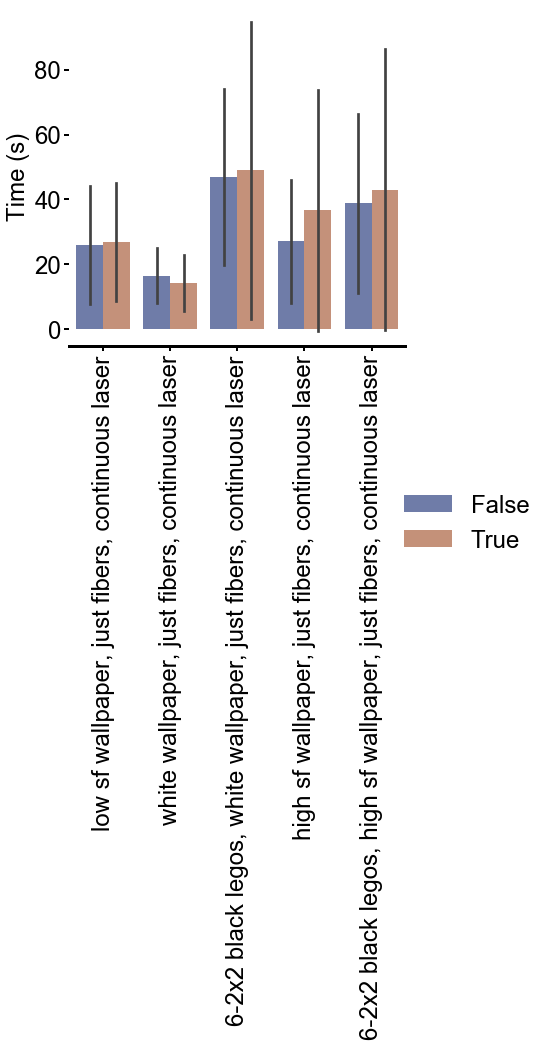

In [36]:
# plt.figure(figsize=(20,20))
g = sns.catplot(
    data=df_meta, kind="bar",
    x="Wallpaper", y="CaptureT", hue="LaserOn",
    ci='sd', palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Time (s)")
g.legend.set_title("")
g.set_xticklabels(rotation=90)